In [1]:
from quad_tree import *
from GA_focus import *
import pygad
import matplotlib.pyplot as plt
from multiprocessing import Pool, Manager
import os
import shutil
import sys

In [2]:
seed = 0
map_name = 'PrimevalIsles'

sub_name = ""
# sub_name = "_no_focus"

# seed = int(sys.argv[1])
# map_name = sys.argv[2]

# if len(sys.argv) > 3:
#     sub_name = sys.argv[3]

random.seed(seed)
np.random.seed(seed)



In [3]:
map_folder = "../final_test_maps/"
maps = os.listdir(map_folder)

try:
    os.mkdir("../final_test_results/")
except:
    pass

for m in maps:
    name = m.split(".")[0]
    try:
        os.mkdir(f"../final_test_results/{name}")
    except:
        pass

In [4]:
result_folder = f"../final_test_results/{map_name}/{seed}{sub_name}"
try:
    shutil.rmtree(result_folder)
except:
    pass
os.mkdir(result_folder)

img = cv2.imread(f"{map_folder}{map_name}.png", cv2.IMREAD_GRAYSCALE)

START, GOAL = start_goal_dict[map_name]
num_generations = gen_num_dict[map_name]

In [5]:
# test quad_tree
t1 = time.time()
quad_tree = build_quad_tree(img)
queue = [quad_tree]

# print(f"time to build QuadTree: {time.time() - t1} s")

quad_tree_img = np.zeros([MAP_SIZE, MAP_SIZE], np.uint8)
obs_blocks = []
free_blocks = []

while queue:
    block = queue.pop(0)
    x0, y0, x1, y1 = block.range
    if block.collision == 1:
        quad_tree_img = cv2.rectangle(quad_tree_img, (x0, y0), (x1, y1), [127], -1)
        quad_tree_img = cv2.rectangle(quad_tree_img, (x0, y0), (x1, y1), [255], 2)
        obs_blocks.append(block)
#         print(f"{node.range} in collision")
    elif block.collision == 0:
        quad_tree_img = cv2.rectangle(quad_tree_img, (x0, y0), (x1, y1), [255], 2)
        free_blocks.append(block)
#         print(f"{node.range} safe")

    else:
        queue += block.children

free_blocks_areas = [block.area for block in free_blocks]
        
# resized = cv2.resize(quad_tree_img, [1000, 1000], interpolation = cv2.INTER_AREA)
# cv2.imshow("resized", resized)
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

In [6]:
# find all islands
island_test_img = np.zeros([MAP_SIZE, MAP_SIZE], np.uint8)

islands, islands_ranges, islands_areas = find_all_islands(obs_blocks, island_test_img)

for island in islands:
    island_test_img = draw_island(island_test_img, island)

# resized = cv2.resize(island_test_img, [1000, 1000], interpolation = cv2.INTER_AREA)
# cv2.imshow("resized", resized)
# cv2.waitKey(0) 
# cv2.destroyAllWindows()

In [7]:
def fitness_func(solution, solution_idx, start, goal):
    segments = []
    if len(solution) == 0:
        segments = [(start, goal)]
    else:
        segments.append((start, solution[0]))
        if len(solution) >= 2:
            for i in range(0, len(solution)-1):
                segments.append((solution[i], solution[i+1]))
        segments.append((solution[-1], goal))
    
    length_cost = 0
    collision_cost = 0
    
    for seg in segments:
        A = seg[0]
        B = seg[1]
        seg_len_cost, seg_col_cost = segment_cost(A, B)
        
#         print(f"segment: {seg}, len_cost: {seg_len_cost}, col_cost: {seg_col_cost}")
        length_cost += seg_len_cost
        collision_cost += seg_col_cost
    
    return 1 / (LENGTH_COEF*(length_cost - euclidean(start[0], start[1], goal[0], goal[1]) + 1) + COLLISION_COEF*collision_cost)



In [8]:
def fitness_func_linear(solution, solution_idx, start, goal):
    segments = []
    if len(solution) == 0:
        segments = [(start, goal)]
    else:
        segments.append((start, solution[0]))
        if len(solution) >= 2:
            for i in range(0, len(solution)-1):
                segments.append((solution[i], solution[i+1]))
        segments.append((solution[-1], goal))
    
    length_cost = 0
    collision_cost = 0
    
    for seg in segments:
        A = seg[0]
        B = seg[1]
        seg_len_cost, seg_col_cost = segment_cost_linear(A, B)
        
#         print(f"segment: {seg}, len_cost: {seg_len_cost}, col_cost: {seg_col_cost}")
        length_cost += seg_len_cost
        collision_cost += seg_col_cost
    
    return 1 / (COLLISION_COEF*collision_cost)



In [9]:
manager = Manager() 
seg_cost_history = manager.dict()

def segment_cost(A, B, ccw_area_test_img=None):
    if (A, B) in seg_cost_history:
        # Note when reading the cost from dictionary, the img will not be updated
        return seg_cost_history[(A, B)]
    x0, y0 = A
    x1, y1 = B
#     print(f"updating {(A, B)}")
    len_cost = euclidean(x0, y0, x1, y1)
    col_cost = 0
    
    intersected_islands_idx = intersected_islands(islands, islands_ranges, A, B)

    for island_idx in intersected_islands_idx:
        island = islands[island_idx]
        island_area = islands_areas[island_idx]
#         ccw_area = calculate_ccw_area_of_island(island, A, B, ccw_area_test_img)
#         col_cost += ccw_area if (ccw_area < 0.5 * islands_areas[island_idx]) else (islands_areas[island_idx] - ccw_area) 
        col_cost += calculate_collision_area_of_island(island, A, B, ccw_area_test_img, island_area)
#         print(f"ccw_area: {ccw_area}, island_area: {islands_areas[island_idx]}")

    seg_cost_history[(A, B)] = [len_cost, col_cost]
    return len_cost, col_cost


def segment_cost_linear(A, B, ccw_area_test_img=None):
    if (A, B) in seg_cost_history:
        # Note when reading the cost from dictionary, the img will not be updated
        return seg_cost_history[(A, B)]
    x0, y0 = A
    x1, y1 = B
#     print(f"updating {(A, B)}")
    len_cost = euclidean(x0, y0, x1, y1)
    col_cost = 0
    
    step_size = 10
    for i in range(0, int(len_cost), step_size):
        x = x0 + int(i / len_cost * (x1 - x0))
        y = y0 + int(i / len_cost * (y1 - y0))
        if not is_collision_free(quad_tree, (x, y)):
            col_cost += 10

    seg_cost_history[(A, B)] = [len_cost, col_cost]
    return len_cost, col_cost

In [10]:
debug = False

def sample_sub_problem_2(path):
    if len(path) == 2:
        return [0, len(path)-1]
    else:
        sub_prob_num = random.choice(range(2, int(3 + len(path) / SUB_PROB_SAMPLE_FACTOR)))
#         print(f"sub_prob_num: {sub_prob_num}")
        if sub_prob_num <= 1:
            return [0, len(path)-1]
        else:
            indices_sample = random.sample(range(1, len(path)-1), k=sub_prob_num-1)
            indices_set = set(indices_sample)
            start_goal_indices = list(indices_set)
            start_goal_indices.sort()
            
            return start_goal_indices


def solve_sub_prob_2(path, gen_budget):
    random.seed(seed)
    np.random.seed(seed)
    
    wp_num = len(path) - 2

    fixed_points_idxs = [0] + sample_sub_problem_2(path) + [len(path)-1]
    fixed_points = [path[idx] for idx in fixed_points_idxs]
    
    num_gen = max(1, int(gen_budget / (len(fixed_points) - 1)))
    
    for i in range(len(fixed_points) - 1):
        sub_start = fixed_points[i]
        sub_goal = fixed_points[i+1]
        
        fitness_type_sub = fitness_func
        crossover_type_sub = my_crossover
        mutation_type_sub = my_mutation

        ga_sub = GA_focus(num_gen, 
                 num_parents_mating_sub, 
                 fitness_func=fitness_type_sub,
                 pop_size=sol_per_pop_sub,
                 initial_population=None,
                 pick_corners=False, 
                 elitism=elitism_sub,
                 keep_parents=keep_parents_sub,
                 selection_type=selection_type_sub,
                 K_tournament=K_tournament_sub,
                 crossover_type=crossover_type_sub,
                 crossover_probability=crossover_probability_sub,
                 mutation_type=mutation_type_sub,
                 mutation_probability=mutation_probability_sub,
                 on_start=None,
                 on_fitness=None,
                 on_parents=None,
                 on_crossover=None,
                 on_mutation=None,
                 delay_after_gen=0.0,
                 save_best_solutions=True,
                 random_seed=None,
                 free_blocks=free_blocks,
                 start_pos=START,
                 goal_pos=GOAL, 
                 islands=islands, 
                 islands_ranges=islands_ranges, 
                 islands_areas=islands_areas,
                 segment_cost_func=segment_cost)

        ga_sub.set_start_goal(sub_start, sub_goal)
    #         print(f"mutation happens on: {path[sub_start_idx:sub_goal_idx+1]}")

        if debug:
            print(f"raw problem: {path}")
            print(f"sub problem: {[sub_start] + init_population[0] + [sub_goal]}")

    #     init_population = [path[sub_start_idx+1:sub_goal_idx].copy() for _ in range(ga_sub.population_size)]
    #     ga_sub.initialize(init_population)
        
        sub_start_idx = path.index(sub_start)
        sub_goal_idx = path.index(sub_goal)
    
        init_population = [[] for _ in range(ga_sub.population_size)]
        ga_sub.initialize(init_population)
        ga_sub.population[0] = path[sub_start_idx+1:sub_goal_idx].copy()

        ga_sub.run()
        solution, solution_fitness, solution_idx = ga_sub.best_solution()

        path[sub_start_idx+1:sub_goal_idx] = solution.copy()
    
    return path[1:-1]


def my_mutation_focus(last_generation_offspring_crossover, mutation_probability, free_blocks, ga_instance):
    offspring = []
    for individual in last_generation_offspring_crossover:
        offspring.append(individual.copy())
        
    mutated_idx = random.sample(range(len(offspring)), k=int(len(offspring) * mutation_probability))
    path_to_mutate = [[ga_instance.start_pos] + offspring[chromosome_idx].copy() + [ga_instance.goal_pos] for chromosome_idx in mutated_idx]
    
    gen_budget = num_generations_sub
        
    if parallelize:
        with Pool(POOL_NUM) as p:
            new_solutions = p.starmap(solve_sub_prob_2, [(path, gen_budget) for path in path_to_mutate])
    else:
        new_solutions = []
        for path in path_to_mutate:
            new_solutions.append(solve_sub_prob_2(path, num_gen))
    
    for i in range(len(mutated_idx)):
        chromosome_idx = mutated_idx[i]
        new_solution = new_solutions[i]
        offspring[chromosome_idx] = new_solution.copy()
    
    
        
    return offspring

In [11]:
debug_mutate = False

def my_mutation(last_generation_offspring_crossover, mutation_probability, free_blocks, ga_instance):
    offspring = []
    for individual in last_generation_offspring_crossover:
        offspring.append(individual.copy())
    
    mutation_types = ["delete", "insert", "move", "split_ang", "split_seg"]
    
    # pick offspring to mutate
    mutated_idx = random.sample(range(len(offspring)), k=int(len(offspring) * mutation_probability))
    
    for chromosome_idx in mutated_idx:
        mutation_weights = [1, 1, 1, 1, 1]
        wp_num = len(offspring[chromosome_idx])

        path = [ga_instance.start_pos] + offspring[chromosome_idx] + [ga_instance.goal_pos]
        segment_col_costs = []
        for i in range(len(path) - 1):
            A, B = path[i], path[i+1]
            segment_col_costs.append(ga_instance.segment_cost_func(A, B)[1])

        # if no collision, do not insert
        if not any(segment_col_costs):
            mutation_weights[1] = 0

        # if no waypoint, do not delete or move waypoint or split angle
        if wp_num == 0:
            mutation_weights[0] = 0
            mutation_weights[2] = 0
            mutation_weights[3] = 0

        mtype = random.choices(mutation_types, mutation_weights)[0]

        if debug_mutate: 
            print(f"before mutation: {offspring[chromosome_idx]}")

        if mtype == "split_seg":
            if debug_mutate:
                print("split_seg")


            # split a segment
            len_weights = []
            for i in range(len(path)-1):
                x0, y0 = path[i]
                x1, y1 = path[i+1]
                len_weights.append(euclidean(x0, y0, x1, y1))

            random_wp_idx = random.choices(range(wp_num+1), len_weights, k=1)[0]
            x0, y0 = path[random_wp_idx]
            x1, y1 = path[random_wp_idx+1]

            dist = 100
            
            for _ in range(100):
                alpha = random.random()
                x_new = int(alpha * x0 + (1 - alpha) * x1 + (random.random() - 0.5) * dist)
                y_new = int(alpha * y0 + (1 - alpha) * y1 + (random.random() - 0.5) * dist)

                if is_collision_free(quad_tree, (x_new, y_new)):
                    offspring[chromosome_idx].insert(random_wp_idx, (x_new, y_new))
                    break

        elif mtype == "split_ang":
            if debug_mutate:
                print("split_ang")


            # cut an angle of two segments
            cos_weights = []
            for i in range(1, len(path)-1):
                a = ga_instance.segment_cost_func(path[i-1], path[i])[0]
                b = ga_instance.segment_cost_func(path[i], path[i+1])[0]
                c = ga_instance.segment_cost_func(path[i-1], path[i+1])[0]
                cos_theta = (a**2 + b**2 - c**2) / (2*a*b)
                cos_weights.append((cos_theta + 1) / 2)

            random_wp_idx = random.choices(range(wp_num), cos_weights, k=1)[0]

            x0, y0 = path[random_wp_idx]
            x, y = path[random_wp_idx+1]
            x1, y1 = path[random_wp_idx+2]

            new_waypoints = []

            for _ in range(100):
                alpha = random.random()
                x_new = int(alpha * x0 + (1 - alpha) * x)
                y_new = int(alpha * y0 + (1 - alpha) * y)

                if is_collision_free(quad_tree, (x_new, y_new)):
                    new_waypoints.append((x_new, y_new))
                    break 

            for _ in range(100):
                alpha = random.random()
                x_new = int(alpha * x1 + (1 - alpha) * x)
                y_new = int(alpha * y1 + (1 - alpha) * y)

                if is_collision_free(quad_tree, (x_new, y_new)):
                    if (x_new, y_new) not in new_waypoints:
                        new_waypoints.append((x_new, y_new))
                        break 

            if len(new_waypoints) > 0:
                if len(new_waypoints) == 1 or new_waypoints[0] != new_waypoints[1]:
                    offspring[chromosome_idx][random_wp_idx:random_wp_idx+1] = new_waypoints


        elif mtype == "move":
            if debug_mutate: 
                print("move")

            random_wp_idx = random.choices(range(wp_num), k=1)[0]

            # random local motion
            x, y = offspring[chromosome_idx][random_wp_idx]
            theta = random.random() * 2 * np.pi
            for _ in range(100):
                dist = random.random() * INSERT_MOVE_DIST
                x_new = int(x + np.cos(theta) * dist)
                y_new = int(y + np.sin(theta) * dist)

                if is_collision_free(quad_tree, (x_new, y_new)) and (x_new, y_new) != (x, y):
                    offspring[chromosome_idx][random_wp_idx] = (x_new, y_new)
                    break


        elif mtype == "delete":
            if debug_mutate: 
                print("delete")

            random_wp_idx = random.choices(range(wp_num), k=1)[0]
            offspring[chromosome_idx].pop(random_wp_idx)

        else:  # if mtype == "insert"
            if debug_mutate: 
                print("insert")

            random_wp_idx = random.choices(range(wp_num+1), segment_col_costs, k=1)[0]
#             random_wp_idx = random.choices(range(wp_num+1), k=1)[0]
            if random.random() > 0.5:
                x, y = path[random_wp_idx]
            else:
                x, y = path[random_wp_idx+1]

            theta = random.random() * 2 * np.pi

            for _ in range(100):
                dist = random.random() * INSERT_MOVE_DIST
                x_new = int(x + np.cos(theta) * dist)
                y_new = int(y + np.sin(theta) * dist)

                if is_collision_free(quad_tree, (x_new, y_new)) and (x_new, y_new) != (x, y):
                    offspring[chromosome_idx].insert(random_wp_idx, (x_new, y_new))
                    break

        if debug_mutate:
            print(f"after mutation: {offspring[chromosome_idx]}")
    
    return offspring

In [12]:
save_process_img = True

def on_fitness(ga_focus, generation_fitness):
    if save_process_img:
        solution_img = cv2.imread(f"{map_folder}{map_name}.png")
        for solution in ga_focus.population:
            solution_img = draw_solution(solution, solution_img, color = [0, 0, 255], start=START, goal=GOAL)
        solution_img = draw_solution(ga_focus.last_generation_elitism, solution_img, color = [0, 255, 0], start=START, goal=GOAL)
        
        cv2.imwrite(f"{result_folder}/result_{ga_focus.generations_completed}.png", solution_img)

    print(f"generation # {ga_focus.generations_completed+1}/{ga_focus.num_generations}", end=", ")
    print(f"elitism fitness: {ga_focus.fitness_func(ga_focus.last_generation_elitism, 0, ga_focus.start_pos, ga_focus.goal_pos)}")
    print(f"seg_cost_history length: {len(seg_cost_history)}")

def on_parents(ga_focus, parents):
    print(f"parents fitness: {[ga_focus.fitness_func(solution, 0, START, GOAL) for solution in parents]}")

def on_mutation(ga_focus, offspring_mutation):
    offspring_crossover = ga_focus.last_generation_offspring_crossover
    for i in range(len(offspring_mutation)):
        if offspring_crossover[i] != offspring_mutation[i]:
            print(offspring_crossover[i])
            print(offspring_mutation[i])
            print()
        

# num_generations = 70

fitness_type = fitness_func
segment_cost_func = segment_cost

if sub_name == "_linear":
    fitness_type = fitness_func_linear
    segment_cost_func = segment_cost_linear

crossover_type = my_crossover
mutation_type = my_mutation_focus

if sub_name != "":
    mutation_type = my_mutation
    num_generations = num_generations_bench
    num_parents_mating = num_parents_mating_bench
    sol_per_pop = sol_per_pop_bench
    


In [13]:
t1 = time.time()

ga_main = GA_focus(num_generations, 
                   num_parents_mating, 
                   fitness_func=fitness_type,
                   pop_size=sol_per_pop,
                   initial_population=None,
                   pick_corners=False, 
                   elitism=elitism,
                   keep_parents=keep_parents,
                   selection_type=selection_type,
                   K_tournament=K_tournament,
                   crossover_type=crossover_type,
                   crossover_probability=crossover_probability,
                   mutation_type=mutation_type,
                   mutation_probability=mutation_probability,
                   on_start=None,
                   on_fitness=on_fitness,
                   on_parents=None,
                   on_crossover=None,
                   on_mutation=None,
                   delay_after_gen=0.0,
                   save_best_solutions=True,
                   random_seed=None,
                   free_blocks=free_blocks,
                   start_pos=START,
                   goal_pos=GOAL, 
                   islands=islands, 
                   islands_ranges=islands_ranges, 
                   islands_areas=islands_areas,
                   segment_cost_func=segment_cost_func)

if sub_name == "":
    ga_main.population = ga_main.mutation(ga_main.population, ga_main.mutation_probability, ga_main.free_blocks, ga_main)

ga_main.run()
solution, solution_fitness, solution_idx = ga_main.best_solution()

time_cost = time.time() - t1
# print(f"GA cost time: {time_cost} s")


/tmp/ipykernel_53017/3232502872.py:76: RuntimeWarning: invalid value encountered in double_scalars
  cos_theta = (a**2 + b**2 - c**2) / (2*a*b)
/tmp/ipykernel_53017/3232502872.py:76: RuntimeWarning: invalid value encountered in double_scalars
  cos_theta = (a**2 + b**2 - c**2) / (2*a*b)


generation # 1/6, elitism fitness: 5.561005324811693e-07
seg_cost_history length: 70048
generation # 2/6, elitism fitness: 6.973672901041299e-05
seg_cost_history length: 100332


/tmp/ipykernel_53017/3232502872.py:76: RuntimeWarning: invalid value encountered in double_scalars
  cos_theta = (a**2 + b**2 - c**2) / (2*a*b)


generation # 3/6, elitism fitness: 0.00028764940248354406
seg_cost_history length: 117033
generation # 4/6, elitism fitness: 0.00028779707367281016
seg_cost_history length: 136041
generation # 5/6, elitism fitness: 0.00031260996286135227
seg_cost_history length: 156037


/tmp/ipykernel_53017/3232502872.py:76: RuntimeWarning: invalid value encountered in double_scalars
  cos_theta = (a**2 + b**2 - c**2) / (2*a*b)


generation # 6/6, elitism fitness: 0.00031832869140023187
seg_cost_history length: 180393


/tmp/ipykernel_53017/3232502872.py:76: RuntimeWarning: invalid value encountered in double_scalars
  cos_theta = (a**2 + b**2 - c**2) / (2*a*b)


In [14]:
solution, solution_fitness, solution_idx = ga_main.best_solution()

path = [START] + solution + [GOAL]
len_cost = []
col_cost = []

for i in range(len(path) - 1):
    A = path[i]
    B = path[i+1]
    
    l, c = segment_cost(A, B)
    len_cost.append(l)
    col_cost.append(c)


In [15]:
print(f"{map_name}{sub_name} round {seed}, solution_fitness: {solution_fitness}")

PrimevalIsles round 0, solution_fitness: 0.0003307688461790344


In [16]:
with open(f"{result_folder}/result.txt", "w") as f:
    f.write(f"time_cost: {time_cost}\n")
    f.write(f"# segments assessed: {len(seg_cost_history)}\n")
    f.write(f"free block count: {len(free_blocks)}\n")
    f.write(f"obstacle block count: {len(obs_blocks)}\n")
    f.write(f"solution_fitness: {solution_fitness}\n")
    f.write(f"len(solution): {len(solution)}\n")
    f.write(f"len_cost: {sum(len_cost)}\n")
    f.write(f"col_cost: {sum(col_cost)}\n")

In [17]:
with open(f"{result_folder}/solution.txt", "w") as f:
    for wp in solution:
        x, y = wp
        f.write(f"{x}, {y}\n")

In [18]:
with open(f"{result_folder}/fitness_history.txt", "w") as f:
    for fit in ga_main.best_solutions_fitness:
        f.write(f"{fit}\n")

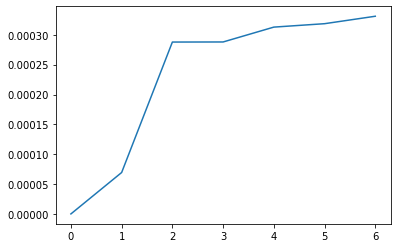

In [19]:
plt.plot(ga_main.best_solutions_fitness)
plt.savefig(f"{result_folder}/fitness_{map_name}.png")

True

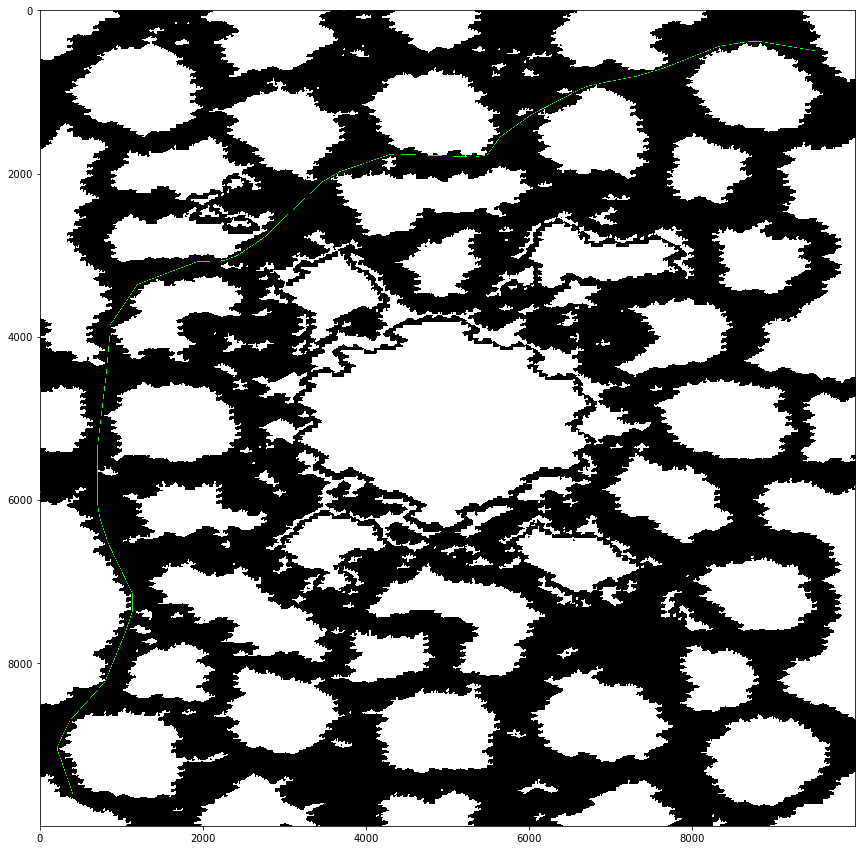

In [20]:
solution_img = cv2.imread(f"{map_folder}{map_name}.png")
solution_img = draw_solution(solution, solution_img, start=START, goal=GOAL)

plt.figure(figsize = (15,15))
plt.imshow(solution_img)

cv2.imwrite(f"{result_folder}/result_{map_name}.png", solution_img)

# resized = cv2.resize(solution_img, [1000, 1000], interpolation = cv2.INTER_AREA)
# cv2.imshow("resized", resized)
# cv2.waitKey(0) 
# cv2.destroyAllWindows()